# Functions to be called throughout the code

In [14]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [15]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

# Libraries

In [16]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import pystan
import time

# Configuring the regression parameters

In [17]:
my_data = pd.read_csv('../../Catalogue/binom_reg_dataset.csv')

In [18]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

# parameters of interest
logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values[index].astype(int)    # y axis: logit class: UVUP yes/no
whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values[index].astype(int)  # My types of galaxies
mass        = my_data['STELLAR_MASS'].values[index].astype(int)                    # 1st parameter
redshift    = redshifts.values[index].astype(float)                                # 2nd parameter

In [19]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
# x2      = mass
y       = logit_class
classes = (whan_class+1).astype(int)        # Must sum +1 to avoid index issues with STAN
n_obs   = x1.size
n_class = np.unique(classes).size

# new parameters - important for plotting!
n_obs2 = 20
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [20]:
print x2.min(), x2.max() # sanity check
print np.median(x2)
print plot_x1.shape

-2.582215516074275 1.5690974667054223
-0.5065590246844265
(400, 1)


In [21]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = regression_data['X'][0,:].size                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['W'] = classes
regression_data['N'] = n_obs
regression_data['C'] = n_class                                      # Number of different classes (partial pooling)

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2)))
regression_data['N2'] = n_obs2**2

In [22]:
# Fit: STAN code ----------------------------------------------------------------------------------------------------------
stan_code = """
// DECLARATION OF VARIABLES -----------------------------------------------------------------------------------------------
data{
    int<lower=1> N;
    int<lower=1> N2;
    int<lower=1> K;
    int<lower=1> C;
    int W[N];
    int<lower=0, upper=1> Y[N];
    matrix[N, K] X;         // redshift and stellar mass 
    matrix[N2,K] X2;        // redshift and stellar mass -- after grid
    }

// DEFINING THE PRIOR(S) --------------------------------------------------------------------------------------------------
parameters{
    matrix[K,C] beta;       // 25 betas!
//    real<lower=0> sigma;    // Shared hyperpriors
//    real mu;                // Shared hyperpriors
    }

// MODEL: PROBABILITY, HYPERPRIORS, PRIORS, AND REGRESSION ----------------------------------------------------------------
model {
   vector[N] prob;
    for (i in 1:N) {
      prob[i] = beta[1,W[i]]*X[i,1] + beta[2,W[i]]*X[i,2] + beta[3,W[i]]*X[i,3] + beta[4,W[i]]*X[i,4] + 
      beta[5,W[i]]*X[i,5];
      }

//    sigma ~ gamma(0.001, 0.001);                           // shared hyperpriors
//    mu ~ normal(0, 100);                                   // shared hyperpriors
     
    for (i in 1:K) {
    for (j in 1:C) beta[i,j] ~ normal(0,1);           // priors
    }

    Y ~ bernoulli_logit(prob);                             // regression
    }

// DATA TO BE PLOTTED -----------------------------------------------------------------------------------------------------
generated quantities{
    vector[N2] prob01;
    vector[N2] eta01;
    vector[N2] prob02;
    vector[N2] eta02;
    vector[N2] prob03;
    vector[N2] eta03;
    vector[N2] prob04;
    vector[N2] eta04;
    vector[N2] prob05;
    vector[N2] eta05;
    
    for(j in 1:N2){
        eta01[j] = beta[1,1]*X2[j,1] + beta[2,1]*X2[j,2] + beta[3,1]*X2[j,3] + beta[4,1]*X2[j,4] + beta[5,1]*X2[j,5];
        prob01[j] = inv_logit(eta01[j]);
        eta02[j] = beta[1,2]*X2[j,1] + beta[2,2]*X2[j,2] + beta[3,2]*X2[j,3] + beta[4,2]*X2[j,4] + beta[5,2]*X2[j,5];
        prob02[j] = inv_logit(eta02[j]);
        eta03[j] = beta[1,3]*X2[j,1] + beta[2,3]*X2[j,2] + beta[3,3]*X2[j,3] + beta[4,3]*X2[j,4] + beta[5,3]*X2[j,5];
        prob03[j] = inv_logit(eta03[j]);
        eta04[j] = beta[1,4]*X2[j,1] + beta[2,4]*X2[j,2] + beta[3,4]*X2[j,3] + beta[4,4]*X2[j,4] + beta[5,4]*X2[j,5];
        prob04[j] = inv_logit(eta04[j]);
        eta05[j] = beta[1,5]*X2[j,1] + beta[2,5]*X2[j,2] + beta[3,5]*X2[j,3] + beta[4,5]*X2[j,4] + beta[5,5]*X2[j,5];   
        prob05[j] = inv_logit(eta05[j]);
        }

    }

"""

### Settings for running STAN

In [23]:
iterations = 5000
chains     = 3                           # HMC chains
warmup     = 1000                        # How many of the first iterations we'll ignore - burnin
jobs       = -1                          # If -1 all CPUs are used. If 1, no parallel computing code is used at all, 
                                         # which is useful for debugging.
seed       = 1

In [25]:
control = {}
control['max_treedepth'] = 20
control['adapt_delta'] = 0.99

### The fit:

In [26]:
start = time.time()

fit = pystan.stan(model_code=stan_code, data=regression_data, seed=seed, iter=iterations, chains=chains, 
                  warmup=warmup, n_jobs=jobs, control=control)

end = time.time()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b924b2d7d95deaf382ca0362400df806 NOW.
/home/mlldantas/anaconda3/envs/py2k7/lib/python2.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpZYaB2o/stanfit4anon_model_b924b2d7d95deaf382ca0362400df806_6038754300703769546.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [27]:
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

--------------------------------------------------
CPU process time: 4.53 [min]
--------------------------------------------------


### Extracting fit properties

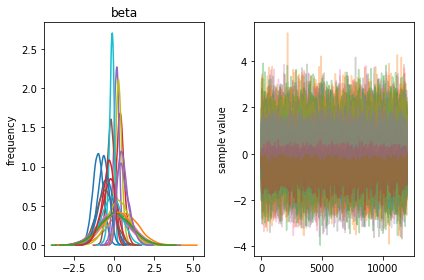

In [28]:
fit.plot('beta')
plt.tight_layout()
plt.show()

In [29]:
summary = pystan.stansummary(fit=fit, digits_summary=5)

In [30]:
summary_arr = np.array(summary.split('\n'))

In [31]:
new_output = summary_arr[5:-6,]                                                    # removing header and footer

In [32]:
print new_output[0]

beta[1,1]   -1.010  0.0032 0.3451 -1.689 -1.239 -1.011 -0.783 -0.330  11353 1.0001


## Formatting fit summary output

In [33]:
header_fit = summary_arr[4].split()
print header_fit

[u'mean', u'se_mean', u'sd', u'2.5%', u'25%', u'50%', u'75%', u'97.5%', u'n_eff', u'Rhat']


In [34]:
header_addendum = 'parameter'
header_fit = [header_addendum] + header_fit
print header_fit

['parameter', u'mean', u'se_mean', u'sd', u'2.5%', u'25%', u'50%', u'75%', u'97.5%', u'n_eff', u'Rhat']


In [35]:
cute_output = list(np.zeros(len(header_fit)))
for i in range(new_output.size):
    if len(new_output[i].split())!=11: # the length of the list must be 11, in which case we connect them directly
#         print "there is a problem!"
        print new_output[i]
    else:
        new_output_temp = np.array(new_output[i].split()).reshape(1,11)
        cute_output     = np.vstack((cute_output, new_output_temp))
cute_output = cute_output[1:,:]               # removing the zeroes in the beggining
print cute_output[:,0].shape

(4025,)


# Saving the fit results

## Saving the probabilities separately for later

In [36]:
probability = {}
probability['prob01'] = list(fit.extract(u'prob01').items()[0])[1]
probability['prob02'] = list(fit.extract(u'prob02').items()[0])[1]
probability['prob03'] = list(fit.extract(u'prob03').items()[0])[1]
probability['prob04'] = list(fit.extract(u'prob04').items()[0])[1]
probability['prob05'] = list(fit.extract(u'prob05').items()[0])[1]

In [37]:
probability['prob01'].shape  # 21000 (3 x 7000) interations for a grid 30x30

(12000, 400)

In [38]:
start = time.time()
for i in range(n_class):
    prob_temp = probability['prob0%d' % int(i+1)]
    prob_tdf = pd.DataFrame(prob_temp)
    prob_tdf.to_csv('../../LargeFilesResults/rm_sharedprior_prob0%d.csv' % int(i+1))
end = time.time()
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

--------------------------------------------------
CPU process time: 0.56 [min]
--------------------------------------------------


 ## Extracting and saving the fit summary

In [39]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
rp      = np.column_stack((plot_x1, recovered_mass))
rp_cols = np.vstack((rp, rp, rp, rp, rp))       # for 5 whan classes we must stack these 5x

In [40]:
parameters = cute_output[:,0].astype(str)
pnew_idxs  = []
for i in range(parameters.size):
    if parameters[i][0:4]=='prob':
        pnew_idxs.append(i)
    else:
        continue
print cute_output[pnew_idxs,:].shape, rp_cols.shape
model_results    = np.column_stack((cute_output[pnew_idxs,:], rp_cols))
model_results_df = pd.DataFrame(model_results)
model_results_df.columns = header_fit + ['Z'] + ['LOG_STELLAR_MASS']
model_results_df.to_csv('../../LargeFilesResults/fit_summary_rm_sharedprior.csv', header=True, index=False)

(2000, 11) (2000, 2)


## Saving the posteriors

In [41]:
posteriors = list(fit.extract(u'beta').items()[0])[1]

In [42]:
print posteriors.shape

(12000, 5, 5)


In [43]:
matrix_row = posteriors[0,:,0].size  # rows are b0, b1, b2, b3, b4 -- posteriors given the regression
matrix_col = posteriors[0,0,:].size  # cols are w0, w1, w2, w3, w4 -- WHAN classification

In [44]:
betas_dict = {}
for line in range(matrix_row):
    for col in range(matrix_col):
        betas_dict["beta%d%d" % (line, col)] = posteriors[:, line, col]
betas_df = pd.DataFrame(betas_dict)

In [45]:
betas_df

beta00    beta01    beta02    beta03    beta04    beta10    beta11  \
0     -1.168913 -0.261863 -0.429306  0.054619 -0.562961  1.467735  0.545294   
1     -1.179026  0.003102 -0.126920  0.382225 -0.403653  1.228847 -0.277700   
2     -1.500214 -0.358376 -0.671970 -0.137142 -0.856082  0.730668  0.064875   
3     -1.226489  0.002499 -1.513871 -0.552496 -1.196429  0.889757  0.924994   
4     -1.024627 -0.080745 -0.863801 -0.240813 -0.403602  0.847798  0.756087   
5     -0.357247 -0.141139 -0.773798 -0.698708 -0.729320 -1.249743 -0.266035   
6     -1.072469 -0.401379 -0.468242 -0.140281 -1.018837 -0.177294  1.192925   
7     -0.894024 -0.170964 -0.482282 -1.051539 -1.119496  1.739555  1.439736   
8     -0.626357  0.101613 -0.020253  1.310590 -0.504980  1.659864  0.207787   
9     -1.220030  0.097549 -0.560356 -0.951068 -0.934396  1.629223 -0.467495   
10    -1.198192 -0.455958 -0.443155 -0.907356 -0.759596  0.109174  1.443989   
11    -0.676413 -0.567872 -0.444096 -0.482675 -0.596490  0.380220  0.520533   
12    -1.092574 -0.283433 -1.017539 -0.678076 -0.861965  0.885411  0.776493   
13    -1.318461 -0.103390 -0.044117 -1.789197 -0.567930  1.320108 -0.410359   
14    -1.678130 -0.245203 -0.284743  0.506633 -0.651695  2.690118  0.378022   
15    -1.181962 -0.232353 -0.814732 -0.603199 -0.893038  1.447109 -0.772744   
16    -0.814394  0.204185 -1.223247 -1.373469  0.036681  0.475511 -0.320892   
17    -1.430904 -0.466485  0.030722 -0.377470 -0.707941  1.000641  0.905007   
18    -1.705819  0.497242 -0.721533 -0.877868 -0.503914  1.132342 -1.660750   
19    -0.885844 -0.215889 -0.081131 -0.780348 -0.853258  0.227539  0.431322   
20    -1.378393 -0.154430 -0.440869 -0.519252 -1.282434  0.375489  0.145315   
21    -0.458752 -0.037435 -0.955860 -1.194702 -1.214517 -0.681626 -0.052247   
22    -1.072813 -0.230926 -0.139177 -0.690304 -0.516044 -1.229108 -0.358328   
23    -1.217240 -0.257222 -0.997398  0.777238 -0.177040  0.858556  0.737955   
24    -1.535026 -0.499113 -0.916307 -0.200818 -0.609892  0.215895  0.855618   
25    -0.850513  0.023168 -1.112519 -1.817254 -0.876813  0.263620  1.070365   
26    -1.576430 -0.064516 -0.939537 -0.617693 -1.112792  1.642258  0.164614   
27    -1.313450 -0.216799 -1.108902  0.108810 -0.770225  0.888970 -0.151605   
28    -1.595392 -0.390577 -1.050132 -0.872414 -0.561942  3.515168  0.005660   
29    -1.325646 -0.148982 -0.687680 -0.537120 -0.498577  0.753447 -0.069745   
...         ...       ...       ...       ...       ...       ...       ...   
11970 -1.101240 -0.028975 -0.901095  0.212666 -0.169095  0.722342 -0.378782   
11971  0.028031 -0.052238 -0.968920 -0.076906 -0.626645 -0.614410 -0.089457   
11972 -1.173761 -0.222759 -0.960016 -1.579352 -0.827420  0.736633  0.307802   
11973 -1.455498 -0.259385 -0.384074  0.105939 -0.329375  0.893355  0.227613   
11974 -0.552874 -0.253595  0.340942 -1.270723 -0.857090 -0.860366  0.073681   
11975 -1.124768 -0.079012  0.173594 -0.502366 -0.088779 -0.084611  0.802455   
11976 -0.633815 -0.293290 -0.148586 -0.544348 -1.402818 -1.400387  1.660003   
11977 -0.519139  0.019207 -0.600543 -0.652760 -1.074666  0.756689 -0.006624   
11978 -0.179918 -0.022201 -0.539061 -0.493855 -0.840353 -1.348837  0.524235   
11979 -1.040629 -0.039184  0.161103 -1.463673 -0.760469 -0.391061 -1.674692   
11980 -1.600303  0.295837 -1.566910 -0.007949 -0.846881  0.005284 -0.001021   
11981 -1.279175 -0.267383 -0.454939 -0.155124 -0.880673  0.861019  0.064006   
11982 -1.188895 -0.253468 -0.679288 -1.330391 -0.399801  1.104412  0.693601   
11983 -1.239559 -0.558175 -0.114821 -1.400732 -0.259039  0.179326  2.305500   
11984 -1.695530 -0.437823 -0.305605 -0.054539 -0.325181  2.079928  0.768850   
11985 -1.171590  0.010527 -0.307074 -0.787074 -1.158590 -0.163199  0.394207   
11986 -1.157273 -0.088427 -0.275934  0.252201 -0.462781  0.717079  1.019139   
11987 -1.153313 -0.503256 -0.911861 -1.720586 -0.487989  0.758986  0.817910   
11988 -0.812210 -0.028518 -0.479836 -1.023145 -0.732324  0.

In [46]:
betas_df.to_csv('./../../LargeFilesResults/betas_rm_sharedprior.csv', header=True, index=False)

## Saving the entire fit -- brace for impact!

In [47]:
start = time.time()
fit_df = fit.to_dataframe()
end = time.time()
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

--------------------------------------------------
CPU process time: 0.47 [min]
--------------------------------------------------


In [48]:
start = time.time()
fit_df.to_csv('../../LargeFilesResults/entirefit_rm_sharedpriors.csv', index=False)
end = time.time()
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

--------------------------------------------------
CPU process time: 1.23 [min]
--------------------------------------------------


In [49]:
fit_df.keys()

Index([u'chain', u'chain_idx', u'warmup', u'accept_stat__', u'energy__',
       u'n_leapfrog__', u'stepsize__', u'treedepth__', u'divergent__',
       u'beta[1,1]',
       ...
       u'eta05[392]', u'eta05[393]', u'eta05[394]', u'eta05[395]',
       u'eta05[396]', u'eta05[397]', u'eta05[398]', u'eta05[399]',
       u'eta05[400]', u'lp__'],
      dtype='object', length=4035)

In [50]:
fit_df

chain  chain_idx  warmup  accept_stat__    energy__  n_leapfrog__  \
0          1          1       0       0.998314  367.365102            63   
1          1          2       0       0.999547  361.079570            63   
2          1          3       0       0.979699  369.714621            31   
3          1          4       0       0.996991  361.800879            63   
4          1          5       0       0.998851  355.058348            63   
5          1          6       0       0.996904  350.788756            63   
6          1          7       0       0.949201  356.727101            63   
7          1          8       0       0.996279  362.835546            63   
8          1          9       0       0.999973  355.992348            63   
9          1         10       0       0.998522  353.394492            31   
10         1         11       0       0.999906  348.108465            63   
11         1         12       0       0.989628  351.298069            63   
12         1         13       0       0.985049  354.575049            31   
13         1         14       0       0.992204  358.718433            63   
14         1         15       0       0.996827  354.698624            63   
15         1         16       0       0.999387  348.279006            63   
16         1         17       0       0.984960  355.451857            63   
17         1         18       0       0.995978  357.045393            63   
18         1         19       0       0.998639  356.257725            63   
19         1         20       0       0.993291  355.705565            63   
20         1         21       0       0.999183  356.875106            63   
21         1         22       0       0.996223  359.244861            63   
22         1         23       0       0.999272  358.695910            63   
23         1         24       0       0.983312  369.473156            63   
24         1         25       0       0.999807  362.999729            63   
25         1         26       0       0.998762  365.105479            63   
26         1         27       0       0.998976  355.457001            63   
27         1         28       0       0.999907  359.319240            63   
28         1         29       0       0.996390  356.513729            63   
29         1         30       0       0.994590  359.423106            63   
...      ...        ...     ...            ...         ...           ...   
11970      3       3971       0       0.993246  361.364844            31   
11971      3       3972       0       0.993726  351.513513            31   
11972      3       3973       0       0.900915  358.645797            31   
11973      3       3974       0       0.988334  359.648021            31   
11974      3       3975       0       0.995506  364.049082            31   
11975      3       3976       0       0.995808  356.987841            95   
11976      3       3977       0       0.962819  356.536867            31   
11977      3       3978       0       0.966719  357.418179            31   
11978      3       3979       0       0.996114  356.113521            31   
11979      3       3980       0       0.950585  355.921714            31   
11980      3       3981       0       0.987830  356.591152            63   
11981      3       3982       0       0.998513  353.412353            31   
11982      3       3983       0       0.994745  358.629671            63   
11983      3       3984       0       0.984076  365.658476            31   
11984      3       3985       0       0.994415  368.106209            31   
11985      3       3986       0       0.981559  358.365521            63   
11986      3       3987       0       0.991167  355.816769            63   
11987      3       3988       0       0.998871  363.500403            31   
11988      3       3989       0       0.995413  364.213917            63   
11989      3       3990       0       0.998494  364.832269            31   
11990      3       3991       0       0.990536  353.936

In [51]:
chain_idx = fit_df['chain_idx'].values.astype(int)
chain     = fit_df['chain'].values.astype(int)
beta11    = fit_df['beta[1,1]'].values.astype(float)
beta12    = fit_df['beta[1,2]'].values.astype(float)
chain1    = np.where(chain==1)
chain2    = np.where(chain==2)
chain3    = np.where(chain==3)

/home/mlldantas/anaconda3/envs/py2k7/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


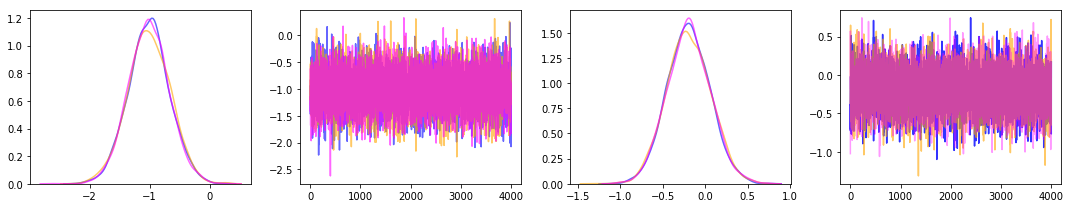

In [52]:
plt.subplots(figsize=(15,3))

plt.subplot(1,4,1)
sns.kdeplot(beta11[chain1], color='blue', alpha=0.6)
sns.kdeplot(beta11[chain2], color='orange', alpha=0.6)
sns.kdeplot(beta11[chain3], color='magenta', alpha=0.6)


plt.subplot(1,4,2)
plt.plot(chain_idx[chain1], beta11[chain1], color='blue', alpha=0.6)
plt.plot(chain_idx[chain2], beta11[chain2], color='orange', alpha=0.6)
plt.plot(chain_idx[chain3], beta11[chain3], color='magenta', alpha=0.6)

plt.subplot(1,4,3)
sns.kdeplot(beta12[chain1], color='blue', alpha=0.6)
sns.kdeplot(beta12[chain2], color='orange', alpha=0.6)
sns.kdeplot(beta12[chain3], color='magenta', alpha=0.6)


plt.subplot(1,4,4)
plt.plot(chain_idx[chain1], beta12[chain1], color='blue', alpha=0.8)
plt.plot(chain_idx[chain2], beta12[chain2], color='orange', alpha=0.6)
plt.plot(chain_idx[chain3], beta12[chain3], color='magenta', alpha=0.4)


plt.tight_layout()
plt.savefig('./Results/example_beta_traceplot_rmsharedprior.png')
plt.show()